In [ ]:
"""
To do:
1) figure out how to feature engineer with images (rotations, crops, etc.)
2) load images and metadata into autoencoder and get predictions
"""

In [1]:
# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from io import BytesIO
from collections import Counter
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance

# Loading the Data...

In [2]:
# Load in the metadata
zip_folder = zipfile.ZipFile('anon-patient-data.zip')
skin_cancer_df = pd.read_csv(zip_folder.open('train-metadata.csv'), low_memory=False, 
                            usecols=[num for num in range(0, 43) if num not in [2, 7]], index_col='isic_id')

# Initialize the ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Load images and extract features using ResNet50 and batch procesing
def extract_features(img):
    """
    Extracts features from a given image
    :param img: an image instance in PIL format
    :return: the image features
    """
    # Preprocess the image to align with ResNet50 requirements
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) 
    
    # Extract features
    features = resnet_model.predict(img_array)
    return features.flatten()

def feature_batch_generator(zip_file, img_size=(224, 224), batch_size=32):
    """
    Loads images and extracts feautres with batch processing and a ResNet50 model
    :param zip_file: the name of the zip folder that contains the data
    :param img_size: the height and width to scale the image to
    :param batch_size: the number of images to process in one batch
    :return: an array of image features for the batch
    """
    # Indetify all the image files from the zipped folder
    with zipfile.ZipFile(zip_file, 'r') as z:
        files = [file for file in z.namelist() if file.startswith('image/') and file.endswith('.jpg')]
        # Employ batch processing to load images and extract features
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            features = []
            for file in batch_files:
                with z.open(file) as img_file:
                    img = load_img(BytesIO(img_file.read()), target_size=img_size)
                    img_features = extract_features(img)
                    features.append(img_features)
            # Return the features of the images in the batch
            yield np.array(features)

# Exploratory Data Analysis of Metadata by Lesion Type (Cancer vs Non-Cancer)

### How balanced is the data?

Out of the 401059 lesions in our dataset, 400666 are not cancerous and 393 are cancerous.


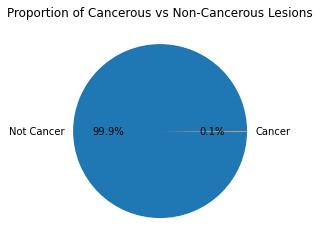

In [3]:
# Report the number of cancerous vs non-cancerous lesions in the data
not_cancer = skin_cancer_df[skin_cancer_df['target'] == 0]
cancer = skin_cancer_df[skin_cancer_df['target'] == 1]
print(f'Out of the {len(skin_cancer_df)} lesions in our dataset, {len(not_cancer)} are not cancerous and {len(cancer)} are cancerous.')

# Visualize the results in a pie chart
fig, ax = plt.subplots()
ax.pie([len(not_cancer), len(cancer)], labels=['Not Cancer', 'Cancer'], autopct='%1.1f%%')
ax.set_title('Proportion of Cancerous vs Non-Cancerous Lesions')
plt.show()

#### The data is heavily imbalanced, with almost all available lesions being non-cancerous. This characteristic of the data is our primary motivator for utilizing anomaly detection rather than binary classification as our method for cancer detection.

### Do men and women make up different proportions of cancerous vs non-cancerous lesions?

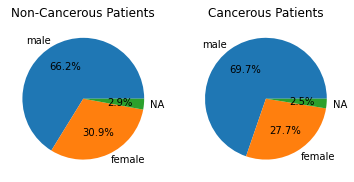

In [17]:
# Obtain the frequencies of each sex for cancerous and non-cancerous lesions
gender_freqs_cancer = Counter(cancer['sex'])
gender_freqs_noncancer = Counter(not_cancer['sex'])

# Visualize the frequencies
fig, ax = plt.subplots(1,2)
ax[0].pie([gender_freqs_noncancer['male'], gender_freqs_noncancer['female'], gender_freqs_noncancer[np.nan]],
       labels=['male', 'female', 'NA'], autopct='%1.1f%%')
ax[0].set_title('Non-Cancerous Patients')
ax[1].pie([gender_freqs_cancer['male'], gender_freqs_cancer['female'], gender_freqs_cancer[np.nan]],
       labels=['male', 'female', 'NA'], autopct='%1.1f%%')
ax[1].set_title('Cancerous Patients')
plt.show()

#### Men are more represented in cancerous lesions than non-cancerous lesions, which aligns with the notion that men are more likely to obtain skin cancer

### Is there a significant difference in the age distribution for cancerous vs non-cancerous patients?

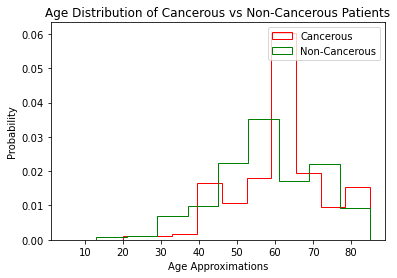

Mann-Whitney U test: U-stat = 67731120.5, p-value = 7.030079099323434e-07
There is a significant difference in the age distribution between cancerous and non-cancerous patients.


In [26]:
# Visualize the age distributions
plt.hist(cancer['age_approx'], histtype='step', color='red', density=True, label='Cancerous')
plt.hist(not_cancer['age_approx'], histtype='step', color='green', density=True, label='Non-Cancerous')
plt.legend()
plt.xlabel('Age Approximations')
plt.ylabel('Probability')
plt.title('Age Distribution of Cancerous vs Non-Cancerous Patients')
plt.show()

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(cancer['age_approx'], not_cancer['age_approx'])

# Print the result
print(f'Mann-Whitney U test: U-stat = {u_stat}, p-value = {p_value}')

# Interpretation
if p_value < 0.05:
    print('There is a significant difference in the age distribution between cancerous and non-cancerous patients.')
else:
    print('There is no significant difference in the age distribution between cancerous and non-cancerous patients.')

### Summary Statistics

In [7]:
# Define the columns to compare summary stats for (choose columns that align with the ABCD factors used for skin cancer detection)
use_cols = ['tbp_lv_symm_2axis', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'clin_size_long_diam_mm']

# Present summary statistics for cancerous patients
cancer[use_cols].describe()

,tbp_lv_symm_2axis,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,clin_size_long_diam_mm
count,393.000000,393.000000,393.000000,393.000000
mean,0.317134,20.730862,1.661645,5.749771
std,0.136708,7.329426,1.450894,3.902299
min,0.076033,11.134446,0.000000,1.010000
25%,0.209040,15.303800,0.289490,2.400000
50%,0.303571,18.325280,1.489238,5.140000
75%,0.400000,24.637490,2.505743,7.870000
max,0.767033,49.869050,8.009495,18.940000


In [8]:
# Present summary statistics for non-cancerous patients
not_cancer[use_cols].describe()

,tbp_lv_symm_2axis,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,clin_size_long_diam_mm
count,400666.000000,400666.000000,400666.000000,400666.000000
mean,0.306813,19.082902,1.069828,3.929043
std,0.125025,5.355337,0.761716,1.738712
min,0.052034,10.761634,0.000000,1.000000
25%,0.211429,15.426310,0.574962,2.840000
50%,0.282258,17.423380,0.931117,3.370000
75%,0.382016,21.010776,1.411450,4.380000
max,0.977055,87.205340,9.952932,28.400000


In [9]:
# Use the Mann-Whitney U test to determine if any of these differences are significant
for col in use_cols:
    u_stat, p_value = stats.mannwhitneyu(cancer[col], not_cancer[col])
    if p_value < 0.05:
        print(f'There is a significant difference in {col} between cancerous and non-cancerous patients.')
    else:
        print(f'There is no significant difference in {col} between cancerous and non-cancerous patients.')

There is no significant difference in tbp_lv_symm_2axis between cancerous and non-cancerous patients.
There is a significant difference in tbp_lv_area_perim_ratio between cancerous and non-cancerous patients.
There is a significant difference in tbp_lv_color_std_mean between cancerous and non-cancerous patients.
There is a significant difference in clin_size_long_diam_mm between cancerous and non-cancerous patients.


### Null Values

In [29]:
# Identify columns with null values for non-cancerous patients
not_cancer_nulls = filter(lambda item: item[1] > 0, not_cancer.isnull().sum().items())
print('Columns with null values for non-cancerous patients:')
for tup in not_cancer_nulls:
    print(f'Column: {tup[0]}, No. of Nulls: {tup[1]}, As a %: {round(tup[1]/len(cancer[tup[0]]), 2)}')
    
# Identify columns with null values for cancerous patients
cancer_nulls = filter(lambda item: item[1] > 0, cancer.isnull().sum().items())
print('\nColumns with null values for cancerous patients:')
for tup in cancer_nulls:
    print(f'Column: {tup[0]}, No. of Nulls: {tup[1]}, As a %: {round(tup[1]/len(cancer[tup[0]]), 2)}')

Columns with null values for non-cancerous patients:
Column: age_approx, No. of Nulls: 2795, As a %: 7.11
Column: sex, No. of Nulls: 11507, As a %: 29.28
Column: anatom_site_general, No. of Nulls: 5756, As a %: 14.65

Columns with null values for cancerous patients:
Column: age_approx, No. of Nulls: 3, As a %: 0.01
Column: sex, No. of Nulls: 10, As a %: 0.03


# Data Preprocessing

In [4]:
# Obtain the categorical (nominal) features
categorical_features = skin_cancer_df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

# Impute and encode values in categorical columns
updated_features = []
for feature in categorical_features:
    
    # Impute null values in categorical features with the mode
    skin_cancer_df[feature] = skin_cancer_df[feature].fillna(skin_cancer_df[feature].mode()[0])
    
    # Apply one-hot encoding to categorical (nominal) variables
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_feature = encoder.fit_transform(skin_cancer_df[[feature]])
    
    # Add the encoded columns to the dataframe
    encoded_col_names = [f"{feature}_{cat}" for cat in encoder.categories_[0]]
    encoded_feature_df = pd.DataFrame(encoded_feature, columns=encoded_col_names, index=skin_cancer_df.index)
    skin_cancer_df = pd.concat([skin_cancer_df, encoded_feature_df], axis=1)
    updated_features += encoded_col_names
    
# Remove unencoded categorical columns
skin_cancer_df = skin_cancer_df.drop(columns=categorical_features)
updated_cols = skin_cancer_df.columns
 
# Use KNN to impute null values in the numerical columns
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(skin_cancer_df)
skin_cancer_df = pd.DataFrame(imputed_array, columns=updated_cols, index=skin_cancer_df.index)

# Feature Engineering

In [5]:
# choosing which features to use from feature engineering
def create_features(df):
    """
    Creates new features to help the model evaluate the ABCD factors used by dermatologists
    :param df: a dataframe to add new features to
    :return: the input dataframe with updated features
    """
    og_cols = len(df.columns)
    # A - Asymmetry, Border irregularity/bluriness, and Diameter (skin cancer diameter usually > 6 mm)
    df['diameter_ratio'] = df['tbp_lv_minorAxisMM'] / df['clin_size_long_diam_mm']
    df['area_irregularity'] = np.abs((np.pi * (df['clin_size_long_diam_mm'] / 2)**2) - (df['tbp_lv_areaMM2'])**(1/2))
    df['perimeter_irregularity'] = np.abs((np.pi * df['clin_size_long_diam_mm']) - df['tbp_lv_perimeterMM'])
    df['area_perimeter_ratio'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] ** 2)
    df['large_diameter'] = [1 if val > 5.5 else 0 for val in df['clin_size_long_diam_mm']] # skin cancer diameters tend to be larger than 6 mm
    df['perimeter_to_area'] = (df['tbp_lv_perimeterMM']**2) / df['tbp_lv_areaMM2']
    df['avg_normalized_irregularity'] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"]) / 2
    
    # Color (variation)  
    df['hc_mean_contrast'] = ((df['tbp_lv_H'] + df['tbp_lv_Hext']) / 2) + ((df['tbp_lv_C'] + df['tbp_lv_Cext']) / 2)
    df['tbp_lv_deltaH'] = np.abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
    df['tbp_lv_deltaC'] = np.abs(df['tbp_lv_C'] + df['tbp_lv_Cext'])
    df['overall_lab_contrast'] = np.sqrt(df['tbp_lv_deltaL']**2 + df['tbp_lv_deltaA']**2 + df['tbp_lv_deltaB']**2)
    df['large_color_variance'] = [1 if val > 4 else 0 for val in df['tbp_lv_color_std_mean']]
    df['average_lab_contrast'] = (df['tbp_lv_deltaL'] + df['tbp_lv_deltaA'] + df['tbp_lv_deltaB']) / 3
    
    # Features to maximize other features
    df['lesion_location'] = np.sqrt(df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2) # l2 norm of lesion coordinates
    print(f'Created {len(df.columns) - og_cols} New Features During Feature Engineering')
    df = df.drop(['tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'], axis=1)

    return df

# Apply feature engineering
skin_cancer_enhanced = create_features(skin_cancer_df.copy())

# Add column containing image paths
skin_cancer_enhanced['image_path'] = pd.Series(skin_cancer_enhanced.index).apply(lambda x:
                                    'train-image/image' + str(x) + '.jpg').values

Created 14 New Features During Feature Engineering


In [6]:
# maybe use these features in feature engineering

def create_new_features(df):
    # Create new features
    df["color_uniformity"] = np.where(df["tbp_lv_radial_color_std_max"] == 0, 0, (df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]))
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2

    return df

skin_cancer_enhanced = create_new_features(skin_cancer_enhanced.copy())

# Correlation Matrix

In [7]:
# Calculate the correlation matrix
og_cols = len(skin_cancer_enhanced.columns)
corr_matrix = skin_cancer_enhanced.corr().abs()

# Remove repetitions by only keeping values in upper, right triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlations to other features greater than 0.8
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
skin_cancer_enhanced = skin_cancer_enhanced.drop(to_drop, axis=1)
print(f'Removed {og_cols - len(skin_cancer_enhanced.columns)} Features with High Correlation to Another Feature')

Removed -34 Features with High Correlation to Another Feature


# Feature Importances

In [37]:
# Calculate feature importances using ANOVA f-test
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif, k='all')
skin_cancer_array = fs.fit_transform(skin_cancer_enhanced.drop(['target', 'image_path'], axis=1), skin_cancer_enhanced['target'])
use_cols = skin_cancer_enhanced.drop(['target', 'image_path'], axis=1).columns

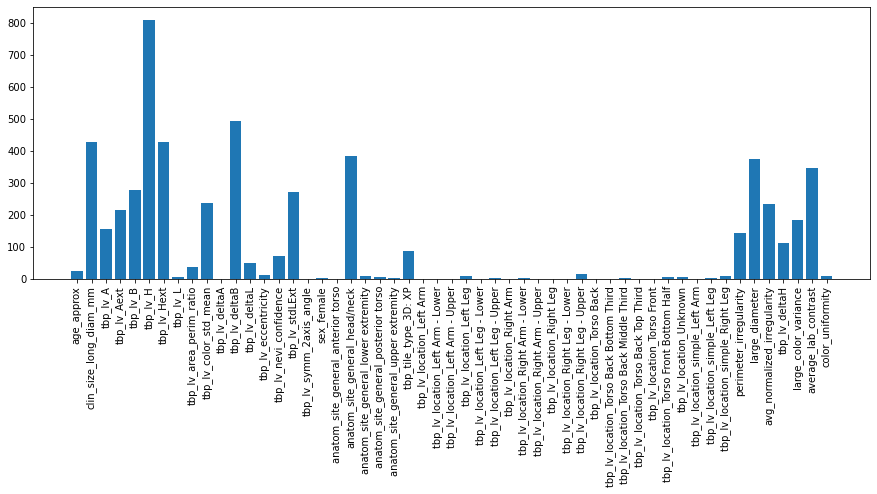

In [38]:
# Plot the feature importances
plt.figure(figsize=(15,5))
plt.bar([use_cols[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation='vertical')
plt.show()

# Isolation Forest - gives worse results than autoencoders

In [58]:
# Hyperparameter tuning - training on non-cancerous patientsw, w/o feature engineering
best = (0, 0, 0, None)
for ss in [x*0.01 for x in range(17, 23, 2)]:
    # Oversample the minority group to make the data more balanced
    smote = SMOTE(sampling_strategy=ss, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(skin_cancer_df.drop('target', axis=1), skin_cancer_df['target'])

    # Split the data - training is non-cancerous, test is on all patients to detect anomalies
    X_train = X_resampled[y_resampled == 0]
    X_test = X_resampled

    # Scale the data between 0 and 1
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Develop and train the Isolation Forest model
    c = len(y_resampled[y_resampled == 1]) / len(y_resampled)
    for estimators in range(50, 120, 10):
        isf = IsolationForest(n_estimators=estimators, contamination=c, random_state=42)
        isf.fit(X_train)

        # Predict the targets for the test data
        preds = isf.predict(X_test)
        y_preds = [1 if p == -1 else 0 for p in preds]

        # Evaluate the models performance on testing data
        cr = classification_report(y_resampled, y_preds)
        f1_score = float(cr.split()[12])
        if f1_score > best[2]:
            best = (ss, estimators, f1_score, cr)
        print(f'\nS.S.: {ss}, Estimators: {estimators}, f1_score: {f1_score}')
        print(cr)
print('Best Hyperparameters + result:', best[:2], '\n', best[3])


S.S.: 0.17, Estimators: 50, f1_score: 0.43
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88    400666
         1.0       0.37      0.50      0.43     68113

    accuracy                           0.80    468779
   macro avg       0.64      0.68      0.65    468779
weighted avg       0.83      0.80      0.82    468779


S.S.: 0.17, Estimators: 60, f1_score: 0.44
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88    400666
         1.0       0.38      0.53      0.44     68113

    accuracy                           0.81    468779
   macro avg       0.65      0.69      0.66    468779
weighted avg       0.84      0.81      0.82    468779


S.S.: 0.17, Estimators: 70, f1_score: 0.43
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88    400666
         1.0       0.38      0.51      0.43     68113

    accuracy                           0.81    468

In [15]:
# Hyperparameter tuning - training on non-cancerous patients, w feature engineering
best = (0, 0, 0, None)
for ss in [x*0.01 for x in range(17, 23, 2)]:
    # Oversample the minority group to make the data more balanced
    smote = SMOTE(sampling_strategy=ss, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(skin_cancer_enhanced.drop(['target', 'image_path'], axis=1), 
                                                  skin_cancer_df['target'])

    # Split the data - training is non-cancerous, test is on all patients to detect anomalies
    X_train = X_resampled[y_resampled == 0]
    X_test = X_resampled

    # Scale the data between 0 and 1
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Develop and train the Isolation Forest model
    c = len(y_resampled[y_resampled == 1]) / len(y_resampled)
    for estimators in range(50, 120, 10):
        isf = IsolationForest(n_estimators=estimators, contamination=c, random_state=42)
        isf.fit(X_train)

        # Predict the targets for the test data
        preds = isf.predict(X_test)
        y_preds = [1 if p == -1 else 0 for p in preds]

        # Evaluate the models performance on testing data
        cr = classification_report(y_resampled, y_preds)
        f1_score = float(cr.split()[12])
        if f1_score > best[2]:
            best = (ss, estimators, f1_score, cr)
        print(f'\nS.S.: {ss}, Estimators: {estimators}, f1_score: {f1_score}')
        print(cr)
print('Best Hyperparameters + result:', best[:2], '\n', best[3])


S.S.: 0.17, Estimators: 50, f1_score: 0.42
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88    400666
         1.0       0.37      0.49      0.42     68113

    accuracy                           0.80    468779
   macro avg       0.64      0.67      0.65    468779
weighted avg       0.83      0.80      0.81    468779


S.S.: 0.17, Estimators: 60, f1_score: 0.44
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88    400666
         1.0       0.38      0.53      0.44     68113

    accuracy                           0.81    468779
   macro avg       0.65      0.69      0.66    468779
weighted avg       0.84      0.81      0.82    468779


S.S.: 0.17, Estimators: 70, f1_score: 0.43
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88    400666
         1.0       0.37      0.51      0.43     68113

    accuracy                           0.80    468

In [25]:
# Hyperparameter tuning - training on non-cancerous patients, w feature engineering and feature importance

# Sample data
X_full = skin_cancer_enhanced.drop(['target', 'image_path'], axis=1)
y_full = skin_cancer_df['target']
X_train = pd.concat([X_full[y_full == 1][:200], X_full[y_full == 0][:250]], ignore_index=True)
y_train = list(y_full[y_full == 1][:200].values) + list(y_full[y_full == 0][:250].values)
X_test = pd.concat([X_full[y_full == 1][200:], X_full[y_full == 0][250:450]], ignore_index=True)
y_test = list(y_full[y_full == 1][200:].values) + list(y_full[y_full == 0][250:450].values)   

# Scale the data between 0 and 1
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Determine important features
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns.to_list())
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns.to_list())
c = len([y for y in y_train if y == 1]) / len(y_train)
isf = IsolationForest(n_estimators=80, contamination=c, random_state=42)
isf.fit(X_train)
result = permutation_importance(isf, X_train, y_train, scoring='f1_weighted', n_repeats=10, random_state=42)
importance_means = result.importances_mean
feature_importances = dict(zip(X_train.columns.to_list(), importance_means))
sorted_importances = sorted(feature_importances.items(), key=lambda x:x[1], reverse=True)
use_features = [item[0] for item in sorted_importances if item[1] > 0]

# Use important features to hyperparameter tune
skin_cancer_enhanced_features = skin_cancer_enhanced.copy().drop(use_features, axis=1)

best = (0, 0, 0, None)
for ss in [x*0.01 for x in range(17, 23, 2)]:
    # Oversample the minority group to make the data more balanced
    smote = SMOTE(sampling_strategy=ss, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(skin_cancer_enhanced_features.drop(['target', 'image_path'], axis=1), 
                                                  skin_cancer_df['target'])

    # Split the data - training is non-cancerous, test is on all patients to detect anomalies
    X_train = X_resampled[y_resampled == 0]
    X_test = X_resampled

    # Scale the data between 0 and 1
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Develop and train the Isolation Forest model
    c = len(y_resampled[y_resampled == 1]) / len(y_resampled)
    for estimators in range(50, 120, 10):
        isf = IsolationForest(n_estimators=estimators, contamination=c, random_state=42)
        isf.fit(X_train)

        # Predict the targets for the test data
        preds = isf.predict(X_test)
        y_preds = [1 if p == -1 else 0 for p in preds]

        # Evaluate the models performance 114on testing data
        cr = classification_report(y_resampled, y_preds)
        f1_score = float(cr.split()[12])
        if f1_score > best[2]:
            best = (ss, estimators, f1_score, cr)
        print(f'\nS.S.: {ss}, Estimators: {estimators}, f1_score: {f1_score}')
        print(cr)
print('Best Hyperparameters + result:', best[:2], '\n', best[3])


S.S.: 0.17, Estimators: 50, f1_score: 0.29
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87    400666
         1.0       0.27      0.32      0.29     68113

    accuracy                           0.78    468779
   macro avg       0.58      0.59      0.58    468779
weighted avg       0.79      0.78      0.78    468779


S.S.: 0.17, Estimators: 60, f1_score: 0.3
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87    400666
         1.0       0.27      0.32      0.30     68113

    accuracy                           0.78    468779
   macro avg       0.58      0.59      0.58    468779
weighted avg       0.79      0.78      0.78    468779


S.S.: 0.17, Estimators: 70, f1_score: 0.3
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87    400666
         1.0       0.28      0.33      0.30     68113

    accuracy                           0.78    46877

In [103]:
from sklearn.tree import DecisionTreeClassifier

In [104]:
dt = DecisionTreeClassifier(random_state=42, criterion = 'gini')
dt.fit(X_train, y_train)
feature_importances_dt = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [106]:
feature_importances_dt[feature_importances_dt > 0]

tbp_lv_H                                   0.234218
clin_size_long_diam_mm                     0.230615
tbp_lv_radial_color_std_max                0.084644
tbp_lv_minorAxisMM                         0.047223
tbp_lv_deltaB                              0.033882
tbp_lv_stdLExt                             0.024059
size_age_interaction                       0.023143
color_uniformity                           0.021359
tbp_lv_Bext                                0.021205
tbp_lv_L                                   0.019266
lesion_size_ratio                          0.018315
tbp_lv_x                                   0.016823
tbp_lv_deltaLBnorm                         0.016383
anatom_site_general_posterior torso        0.016336
log_lesion_area                            0.016013
tbp_lv_nevi_confidence                     0.015753
lesion_color_difference                    0.015429
3d_position_distance                       0.014521
lesion_severity_index                      0.014469
tbp_lv_C    

# Autoencoder - use permutation feauture importances and give it autoencoder

In [22]:
# Hyperparameter tuning - training on non-cancerous patients, w feature engineering
best = (0, 0, 0, None)
# Oversample the minority group to make the data more balanced
for ss in range(5, 35, 10):
    smote = SMOTE(sampling_strategy=ss*0.01, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(skin_cancer_enhanced.drop(['target', 'image_path'], axis=1), 
                                                  skin_cancer_df['target'])

    # Split the data - training is non-cancerous, test is on all patients to detect anomalies
    X_train = X_resampled[y_resampled == 0]
    X_test = X_resampled

    # Scale the data between 0 and 1
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the autoencoder model - dropout of 5 works best
    for d in range(0, 10, 2):
        
        autoencoder = Sequential([
            Dense(128, input_dim=X_train.shape[1], activation='relu'),
            Dropout(d*0.1),  
            Dense(64, activation='relu'),
            Dropout(d*0.1),
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dropout(d*0.1),
            Dense(128, activation='relu'),
            Dropout(d*0.1),
            Dense(X_train.shape[1], activation='sigmoid')  # Output layer should match input
        ])

        autoencoder.compile(optimizer='adam', loss='mse')

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the autoencoder using only the non-cancerous patients
        history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1,
                                 callbacks=[early_stopping])

        # Find the epoch with the lowest validation loss
        best_epoch = np.argmin(history.history['val_loss']) + 1  # Add 1 since epochs are 1-indexed
        best_val_loss = np.min(history.history['val_loss'])

        # Calculate reconstruction error for each sample
        reconstructed = autoencoder.predict(X_test)
        reconstruction_error = np.mean(np.abs(reconstructed - X_test), axis=1)

        # Threshold the reconstruction error to detect anomalies
        for thresh in range(97, 100):
            threshold = np.percentile(reconstruction_error, thresh)  # Set threshold (e.g., 99th percentile)
            predictions_autoencoder = (reconstruction_error > threshold).astype(int)  # 1 = anomaly (cancer), 0 = normal
            cr = classification_report(y_resampled, predictions_autoencoder)
            f1_score = float(cr.split()[12])
            print(f'\nS.S.: {ss*.01}, Dropout: {d*.1}, Threshold: {thresh}, Best Epoch {best_epoch}',
                  f'f1 score: {f1_score}\n', cr)
            if f1_score > best[2]:
                best = (ss, d, thresh, best_epoch, f1_score, cr)

print('Best:')
print(best[:4])
print(best[5])

Epoch 1/100
11269/11269 [==============================] - 25s 2ms/step - loss: 0.0026 - val_loss: 3.0349e-04
Epoch 2/100
11269/11269 [==============================] - 27s 2ms/step - loss: 2.3854e-04 - val_loss: 1.4470e-04
Epoch 3/100
11269/11269 [==============================] - 26s 2ms/step - loss: 0.0050 - val_loss: 1.6025e-04
Epoch 4/100
11269/11269 [==============================] - 26s 2ms/step - loss: 1.5998e-04 - val_loss: 1.3420e-04
Epoch 5/100
11269/11269 [==============================] - 27s 2ms/step - loss: 0.0034 - val_loss: 0.0059
Epoch 6/100
11269/11269 [==============================] - 34s 3ms/step - loss: 0.0014 - val_loss: 1.0507e-04
Epoch 7/100
11269/11269 [==============================] - 28s 2ms/step - loss: 9.6442e-04 - val_loss: 1.0535e-04
Epoch 8/100
11269/11269 [==============================] - 26s 2ms/step - loss: 1.5342e-04 - val_loss: 8.3812e-05
Epoch 9/100
11269/11269 [==============================] - 31s 3ms/step - loss: 1.3002e-04 - val_loss: 7.703

KeyboardInterrupt: 

In [26]:
# Hyperparameter tuning - training on non-cancerous patients, w feature engineering and feature importances

# Use important features to hyperparameter tune
skin_cancer_enhanced_features = skin_cancer_enhanced.copy().drop(use_features, axis=1)

best = (0, 0, 0, None)
# Oversample the minority group to make the data more balanced
for ss in range(5, 35, 10):
    smote = SMOTE(sampling_strategy=ss*0.01, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(skin_cancer_enhanced_features.drop(['target', 'image_path'], axis=1), 
                                                  skin_cancer_df['target'])

    # Split the data - training is non-cancerous, test is on all patients to detect anomalies
    X_train = X_resampled[y_resampled == 0]
    
    # reduce training size and then split remainder of training into validation and test - for training, just use a 
    # subset of non-cancerous, then use remainder with cancerous patients to form the validation and test sets
    X_test = X_resampled

    # Scale the data between 0 and 1
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the autoencoder model - dropout of 5 works best
    for d in range(0, 10, 2):
        
        autoencoder = Sequential([
            Dense(128, input_dim=X_train.shape[1], activation='relu'),
            Dropout(d*0.1),  
            Dense(64, activation='relu'),
            Dropout(d*0.1),
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dropout(d*0.1),
            Dense(128, activation='relu'),
            Dropout(d*0.1),
            Dense(X_train.shape[1], activation='sigmoid')  # Output layer should match input
        ])

        autoencoder.compile(optimizer='adam', loss='mse')

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the autoencoder using only the non-cancerous patients
        history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1,
                                 callbacks=[early_stopping])

        # Find the epoch with the lowest validation loss
        best_epoch = np.argmin(history.history['val_loss']) + 1  # Add 1 since epochs are 1-indexed
        best_val_loss = np.min(history.history['val_loss'])

        # Calculate reconstruction error for each sample
        reconstructed = autoencoder.predict(X_test)
        reconstruction_error = np.mean(np.abs(reconstructed - X_test), axis=1)

        # Threshold the reconstruction error to detect anomalies
        for thresh in range(97, 100):
            threshold = np.percentile(reconstruction_error, thresh)  # Set threshold (e.g., 99th percentile)
            predictions_autoencoder = (reconstruction_error > threshold).astype(int)  # 1 = anomaly (cancer), 0 = normal
            cr = classification_report(y_resampled, predictions_autoencoder, labels=['Not Cancer', 'Cancer'])
            f1_score = float(cr.split()[12])
            print(f'\nS.S.: {ss*.01}, Dropout: {d*.1}, Threshold: {thresh}, Best Epoch {best_epoch}',
                  f'f1 score: {f1_score}\n', cr)
            if f1_score > best[2]:
                best = (ss, d, thresh, best_epoch, f1_score, cr)

print('Best:')
print(best[:4])
print(best[5])

Epoch 1/100
11269/11269 [==============================] - 53s 4ms/step - loss: 0.0019 - val_loss: 1.5359e-04
Epoch 2/100
11269/11269 [==============================] - 52s 5ms/step - loss: 0.0063 - val_loss: 0.0186
Epoch 3/100
11269/11269 [==============================] - 53s 5ms/step - loss: 0.0167 - val_loss: 4.8173e-05
Epoch 4/100
11269/11269 [==============================] - 50s 4ms/step - loss: 9.1448e-05 - val_loss: 7.3300e-05
Epoch 5/100
11269/11269 [==============================] - 50s 4ms/step - loss: 0.0063 - val_loss: 0.0150
Epoch 6/100
11269/11269 [==============================] - 53s 5ms/step - loss: 0.0034 - val_loss: 5.9904e-05
Epoch 7/100
11269/11269 [==============================] - 52s 5ms/step - loss: 8.8739e-05 - val_loss: 2.5834e-05
Epoch 8/100
11269/11269 [==============================] - 53s 5ms/step - loss: 0.0123 - val_loss: 3.8658e-05
Epoch 9/100
11269/11269 [==============================] - 47s 4ms/step - loss: 4.1844e-05 - val_loss: 2.6004e-05
Epoch 

KeyboardInterrupt: 

In [ ]:
# Hyperparameter tuning - training on non-cancerous patients, w/o feature engineering
best = (0, 0, 0, None)
# Oversample the minority group to make the data more balanced
for ss in range(5, 35, 10):
    smote = SMOTE(sampling_strategy=ss*0.01, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(skin_cancer_enhanced.drop('target', axis=1), 
                                                  skin_cancer_df['target'])

    # Split the data - training is non-cancerous, test is on all patients to detect anomalies
    X_train = X_resampled[y_resampled == 0]
    X_test = X_resampled

    # Scale the data between 0 and 1
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the autoencoder model - dropout of 5 works best
    for d in range(0, 10, 2):
        
        autoencoder = Sequential([
            Dense(128, input_dim=X_train.shape[1], activation='relu'),
            Dropout(d*0.1),  
            Dense(64, activation='relu'),
            Dropout(d*0.1),
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dropout(d*0.1),
            Dense(128, activation='relu'),
            Dropout(d*0.1),
            Dense(X_train.shape[1], activation='sigmoid')  # Output layer should match input
        ])

        autoencoder.compile(optimizer='adam', loss='mse')

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the autoencoder using only the non-cancerous patients
        history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1,
                                 callbacks=[early_stopping])

        # Find the epoch with the lowest validation loss
        best_epoch = np.argmin(history.history['val_loss']) + 1  # Add 1 since epochs are 1-indexed
        best_val_loss = np.min(history.history['val_loss'])

        # Calculate reconstruction error for each sample
        reconstructed = autoencoder.predict(X_test)
        reconstruction_error = np.mean(np.abs(reconstructed - X_test), axis=1)

        # Threshold the reconstruction error to detect anomalies
        for thresh in range(97, 100):
            threshold = np.percentile(reconstruction_error, thresh)  # Set threshold (e.g., 99th percentile)
            predictions_autoencoder = (reconstruction_error > threshold).astype(int)  # 1 = anomaly (cancer), 0 = normal
            cr = classification_report(y_resampled, predictions_autoencoder)
            f1_score = float(cr.split()[12])
            print(f'\nS.S.: {ss*.01}, Dropout: {d*.1}, Threshold: {thresh}, Best Epoch {best_epoch}',
                  f'f1 score: {f1_score}\n', cr)
            if f1_score > best[2]:
                best = (ss, d, thresh, best_epoch, f1_score, cr)

print('Best:')
print(best[:4])
print(best[5])